# Entropy as a Predictor for Intraday Volatility in FX

We consider entropy as an estimator of intraday volatility. 'True' volatility is calculated as the 15 minute returns standard deviation across the day, whilst entropy is calculated using the same data - where we aim to estimate the volatility for the following day. This is done as opposed to estimates based on a rolling window.

Various entropy measures and predictive relationships are explored between entropy and volatility. We consider a GARCH + entropy measurement, linear regression, then non linear estimates based on decision trees, gradient boosting trees.

Given the volatility is not actually observed, we also apply our best estimator within a Kalman filter to attempt to form better estimates.

We initially use EURUSD data, then extend to other currency pairs. We begin working on low frequency data, looking later at higher frequency data to see if the model atill holds, taking advantage of the use of neural networks where we not have more data.
As an extension, we use mutual information as a way to estimate currency pair correlation, and hence the 'driving currency' of volatility. This could in theory be used to predict covariance matrices maybe?

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
sys.path.append('..')

In [142]:
path = 'C:/Users/camer/OneDrive/Documents/dev/home_research/data/volatility_entropy_project_fx/'

In [202]:
eurusd_data = pd.read_csv(path + 'EURUSD-2000-2020-15m.csv')[['DATE_TIME', 'CLOSE']]
eurusd_data

,DATE_TIME,CLOSE
0,2000.01.03 00:00:00,1.00770
1,2000.01.03 00:15:00,1.00860
2,2000.01.03 00:30:00,1.00790
3,2000.01.03 00:45:00,1.01280
4,2000.01.03 01:00:00,1.01220
...,...,...
500746,2020.03.19 05:00:00,1.08895
500747,2020.03.19 05:15:00,1.08872
500748,2020.03.19 05:30:00,1.09086
500749,2020.03.19 05:45:00,1.08970


In [203]:
eurusd_data['date'] = pd.to_datetime(eurusd_data['DATE_TIME'])

In [32]:
eurusd_data['ret'].mean()

1.5613786810865325e-07

In [40]:
daily_vol_eurusd = eurusd_data[['date', 'ret_sqd']].groupby('date').mean().rename({'ret_sqd': 'vol'}, axis=1)

<Axes: xlabel='date'>

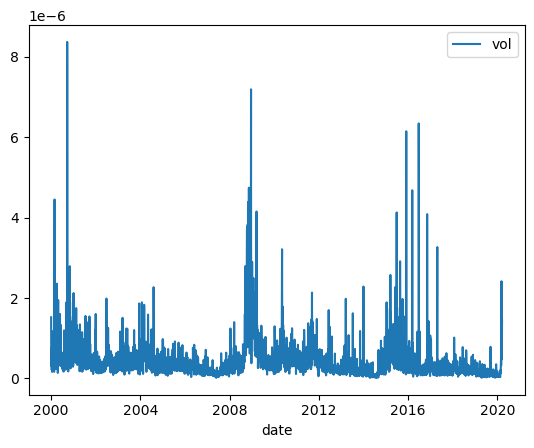

In [41]:
daily_vol_eurusd.plot()

In [43]:
from helper_functions.afml_functions.afml_modelling_lib import encode_and_entropy

In [50]:
daily_entropy_eurusd = eurusd_data[['date', 'ret']].groupby('date').apply(lambda x: encode_and_entropy(x['ret'], 10, 3)) #.rename({'ret': 'entropy'}, axis=1)

C:\Users\camer\AppData\Local\Temp\ipykernel_39360\15188886.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_entropy_eurusd = eurusd_data[['date', 'ret']].groupby('date').apply(lambda x: encode_and_entropy(x['ret'], 10, 3)) #.rename({'ret': 'entropy'}, axis=1)


<Axes: xlabel='date'>

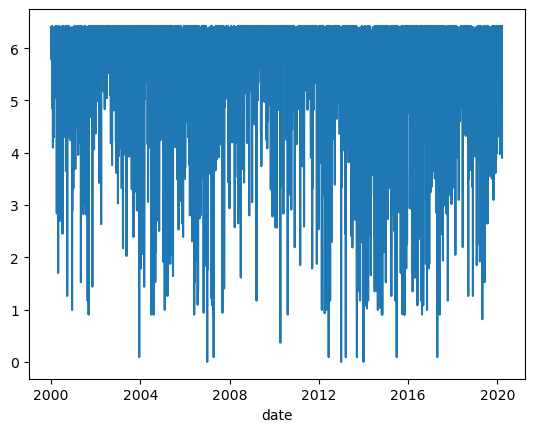

In [51]:
daily_entropy_eurusd.plot()

In [92]:
import statsmodels.api as sm

,date,ret_sqd
0,2000-01-03,NaN
1,2000-01-03,7.969568e-07
2,2000-01-03,4.820140e-07
3,2000-01-03,2.352070e-05
4,2000-01-03,3.511660e-07
...,...,...
500746,2020-03-19,7.299970e-07
500747,2020-03-19,4.462020e-08
500748,2020-03-19,3.856046e-06
500749,2020-03-19,1.131983e-06


In [165]:
eurusd_data = eurusd_data.drop('DATE_TIME', axis=1)

In [166]:
eurusd_data

,CLOSE,date
0,1.00770,2000-01-03 00:00:00
1,1.00860,2000-01-03 00:15:00
2,1.00790,2000-01-03 00:30:00
3,1.01280,2000-01-03 00:45:00
4,1.01220,2000-01-03 01:00:00
...,...,...
500746,1.08895,2020-03-19 05:00:00
500747,1.08872,2020-03-19 05:15:00
500748,1.09086,2020-03-19 05:30:00
500749,1.08970,2020-03-19 05:45:00


In [204]:
eurusd_data['date'] = pd.to_datetime(eurusd_data['date'].dt.date)
eurusd_data_daily = eurusd_data_daily.groupby('date').tail(1)
eurusd_data_daily['ret'] = np.log(eurusd_data_daily['CLOSE']/eurusd_data_daily['CLOSE'].shift())
eurusd_data_daily

,CLOSE,date,ret
95,1.02460,2000-01-03,NaN
189,1.02920,2000-01-04,0.004480
285,1.03260,2000-01-05,0.003298
381,1.03300,2000-01-06,0.000387
477,1.02980,2000-01-07,-0.003103
...,...,...,...
500437,1.11023,2020-03-13,-0.005766
500533,1.11775,2020-03-16,0.006751
500629,1.10055,2020-03-17,-0.015508
500725,1.09114,2020-03-18,-0.008587


In [205]:
import itertools
best_rsqd = 0
best_qL = (2, 10)
for q, L in itertools.product([9, 10, 11], [14, 15, 16]):
    entropy_prev_day = eurusd_data[['date', 'ret']].dropna().groupby('date').apply(lambda x: encode_and_entropy(x['ret'], L, q)).shift()
    mod = sm.OLS(eurusd_data[['date', 'ret_sqd']].set_index('date').groupby('date').mean().iloc[1:], entropy_prev_day.dropna())
    res = mod.fit()
    print(q, L, res.rsquared)
    best_rsqd = max(res.rsquared, best_rsqd)
    if res.rsquared == best_rsqd:
        best_qL = (q, L)
print(best_qL, best_rsqd)

KeyError: "['ret'] not in index"

#### this low frequency data kinda seems worse
lets:
- re-look at how to calculate entropy
- re-look at how to calculate/estimate variance (just use r^2 or rolling value)
- then lets re-look at the estimators

In [71]:
from arch import arch_model

In [179]:
eurusd_data_daily.set_index('date', inplace=True)

In [180]:
eurusd_data_daily

,CLOSE,ret
date,,
2000-01-03 00:00:00,1.00770,NaN
2000-01-03 00:15:00,1.00860,0.000893
2000-01-03 00:30:00,1.00790,-0.000694
2000-01-03 00:45:00,1.01280,0.004850
2000-01-03 01:00:00,1.01220,-0.000593
...,...,...
2020-03-19 05:00:00,1.08895,0.000854
2020-03-19 05:15:00,1.08872,-0.000211
2020-03-19 05:30:00,1.09086,0.001964


In [209]:
eurusd_data_daily.set_index('date', inplace=True)

In [214]:
eurusd_ret.index = pd.to_datetime(eurusd_ret.index)

In [216]:
from datetime import datetime

#index = eurusd_data_daily.index
#end_loc = np.where(index >= "2000-01-05")[0].min()

# eurusd_ret = eurusd_data_daily['ret'].dropna()
am = arch_model(eurusd_ret, vol="Garch", p=1, o=0, q=1, dist="Normal")
res = am.fit(last_obs="2001-01-04", update_freq=5) # fits up to last obs, then applies the forecasts to the observations as they come in (I don't think we are just doing a forecast using prev estimate, we should be using observation)
forecasts = res.forecast()
print(forecasts.variance.dropna().head())

Iteration:      5,   Func. Count:     54,   Neg. LLF: 2251.199097291702
Optimization terminated successfully    (Exit mode 0)
            Current function value: -906.8959488230971
            Iterations: 13
            Function evaluations: 95
            Gradient evaluations: 9
                 h.1
date                
2001-01-03  0.000064
2001-01-04  0.000069
2001-01-05  0.000068
2001-01-08  0.000067
2001-01-09  0.000066


C:\Users\camer\anaconda3\envs\home_research\lib\site-packages\arch\univariate\base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 5.781e-05. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


In [217]:
forecasts.variance

,h.1
date,
2001-01-03,0.000064
2001-01-04,0.000069
2001-01-05,0.000068
2001-01-08,0.000067
2001-01-09,0.000066
...,...
2020-03-13,0.000058
2020-03-16,0.000058
2020-03-17,0.000059


In [ ]:
# define model
model = arch_model(eurusd_data['ret'], mean='Zero', vol='GARCH', p=1, q=1)
# fit model
model_fit = model.fit()
# forecast the test set
yhat = model_fit.forecast(horizon=n_test) # we don't actually want to forecast here
# plot the actual variance
var = [i*0.01 for i in range(0,100)]
pyplot.plot(var[-n_test:])
# plot forecast variance
pyplot.plot(yhat.variance.values[-1, :])
pyplot.show()

#### Later:
- look at garch model volatility and see if it predicts volatility correctly --> note that with garch we get a prediction of vol for every time point so be careful with this, look at how other papers have handled volatility. Thinking about what the book was saying, I think we'd just need to use daily returns here to estimate the volatility, not the fine grain stuff (the finer grain vol provides the better estimate by just using the estimators, this is why the book suggested we needed to use fine grain volatility).
- compare garch model to entropy predicted model --> still take a look at the ratio of sequence length to total length and q etc for entropy estimation; might be better to look at higher frequency data for this reason (we could still do daily returns but with 1 minute time points)
- look at combining the two, should probably make garch/prev day volatility the benchmark
- Form a solid univariate model connecting entropy estimation to volatility
- Perhaps then look at multivariate, bring in mutual entropy/information and see if we can predict the entire covariance matrix